# About Dataset
This dataset provides remote sensing observations of soil moisture for the year 2013, specifically for regions within Germany. The data captures various attributes that are essential for understanding and modeling soil moisture dynamics.

Features:

time: Timestamp of the observation.
latitude: Latitude coordinate of the observation location.
longitude: Longitude coordinate of the observation location.
clay_content: Percentage of clay content in the soil.
sand_content: Percentage of sand content in the soil.
silt_content: Percentage of silt content in the soil.
sm_aux: Soil moisture observation from the SMOS-ASCAT satellite (smoothed).
sm_tgt: Soil moisture observation from the AMSR satellite.
Context:

Soil moisture is a critical variable in hydrology, agriculture, and climate science. Remote sensing provides an effective way to monitor soil moisture across large areas. This dataset, focusing on Germany for the year 2013, offers insights into the spatial and temporal variations of soil moisture and its relation to soil properties.

Use Cases:

- Understanding the distribution and dynamics of soil moisture across Germany.
- Investigating the relationship between soil properties (clay, sand, silt content) and soil moisture.
- Developing predictive models for soil moisture using remote sensing data.

In [ ]:
# Standard Libraries
import pandas as pd
import numpy as np
import json
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, LabelEncoder

import os
os.chdir("C:/Users/USER/Desktop/GitHub/PREDICTING-SOIL-MOISTURE-USING-SOIL-TEXTURE-AND-SATELLITE-DATA")

# Load and Explore dataset

## Load Dataset

In [ ]:
DATA_PATH = os.getenv("DATA_PATH", default="data/updated_data.csv")

df = pd.read_csv(DATA_PATH)
df.head()

,time,latitude,longitude,clay_content,sand_content,silt_content,sm_aux,sm_tgt
0,2013-01-03,54.875,9.125,5.0,86.0,9.0,0.454120,0.53
1,2013-01-05,54.875,9.125,5.0,86.0,9.0,0.437102,0.44
2,2013-01-07,54.875,9.125,5.0,86.0,9.0,0.412978,0.42
3,2013-01-08,54.875,9.125,5.0,86.0,9.0,0.378734,0.55
4,2013-01-09,54.875,9.125,5.0,86.0,9.0,0.350740,0.46


In [ ]:
# Write the columns to a configuration file
COLUMN_CONFIG = os.getenv("COLUMN_CONFIG", default="config/columns.json")
with open(COLUMN_CONFIG, "w") as f:
    # Convert the columns to json and write to the file
    columns = {col: df[col].dtype.name for col in df.columns}
    json.dump(columns, f)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321584 entries, 0 to 321583
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   time          321584 non-null  object 
 1   latitude      321584 non-null  float64
 2   longitude     321584 non-null  float64
 3   clay_content  321584 non-null  float64
 4   sand_content  321584 non-null  float64
 5   silt_content  321584 non-null  float64
 6   sm_aux        321584 non-null  float64
 7   sm_tgt        321584 non-null  float64
dtypes: float64(7), object(1)
memory usage: 19.6+ MB


### Dataset Overview

The dataset contains **321,584 rows** and **8 columns**. Below is a summary of the columns:

1. **time**: Timestamps (non-null, object type) representing the date of observation.
2. **latitude**: Latitude of the observation (non-null, float64 type).
3. **longitude**: Longitude of the observation (non-null, float64 type).
4. **clay_content**: Percentage of clay in the soil (non-null, float64 type).
5. **sand_content**: Percentage of sand in the soil (non-null, float64 type).
6. **silt_content**: Percentage of silt in the soil (non-null, float64 type).
7. **sm_aux**: Auxiliary soil moisture measurement (non-null, float64 type).
8. **sm_tgt**: Target soil moisture measurement (non-null, float64 type).

- **No missing values**: All columns have non-null entries.

This dataset is clean and ready for further exploration and preprocessing steps.


In [ ]:
df.shape

(321584, 8)

## Summary Statistics of the Dataset

In [ ]:
df.describe()

,latitude,longitude,clay_content,sand_content,silt_content,sm_aux,sm_tgt
count,321584.000000,321584.000000,321584.00000,321584.000000,321584.000000,321584.000000,321584.000000
mean,50.840357,9.622973,20.88792,39.242963,39.894503,0.194109,0.411891
std,1.646484,3.789899,7.92268,21.846045,15.229785,0.088552,0.110530
min,48.125000,2.125000,4.00000,6.000000,8.000000,-0.038657,0.010000
25%,49.375000,6.625000,13.00000,22.000000,25.000000,0.126050,0.350000
50%,50.875000,9.875000,22.00000,32.000000,44.000000,0.178973,0.420000
75%,52.125000,12.875000,27.00000,61.000000,51.000000,0.257252,0.490000
max,54.875000,15.875000,46.00000,86.000000,72.000000,0.802321,0.600000


### Dataset Summary Statistics

- **Row count**: 321,584  
- **Key observations**:  
  - Soil texture components (`clay_content`, `sand_content`, `silt_content`) range widely with varying distributions.  
  - Target soil moisture (`sm_tgt`) ranges from **0.01** to **0.6**, with a mean of **0.4119**.  
  - Auxiliary soil moisture (`sm_aux`) shows variability, with values ranging from **-0.0387** to **0.8023**.  

These statistics indicate diverse soil properties and moisture levels for analysis.


In [ ]:
df.describe(include = 'object')

,time
count,321584
unique,363
top,2013-08-19
freq,1119


In [ ]:
# Save a copy for cleaning step
output_path = "data/data_inspection_output.csv"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
df.to_csv(output_path, index=False)
print(f"Data saved to {output_path}")

Data saved to data/data_inspection_output.csv


# Data Cleaning and Preprocessing

- Handle missing values, duplicates, and outliers.
- Normalize or scale the features (clay_content, sand_content, etc.).
- Convert time to datetime format and extract relevant features (e.g., year, month).

## Missing Values

In [ ]:
# Load data from inspection step
input_path = "data/data_inspection_output.csv"
df = pd.read_csv(input_path)

In [ ]:
df.isna().sum()

time            0
latitude        0
longitude       0
clay_content    0
sand_content    0
silt_content    0
sm_aux          0
sm_tgt          0
dtype: int64

We can see that there are no missing values in the dataset

## Duplicate Values

In [ ]:
df.duplicated().sum()

0

There are no Duplicate values in the dataset.

## Outliers

In [ ]:
def detect_outliers(df, threshold=1.5):
    """
    Detect outliers in a DataFrame using the IQR method.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        threshold (float): The multiplier for the IQR to define outlier boundaries.
        
    Returns:
        dict: A dictionary with column names as keys and counts of outliers as values.
    """
    # Automatically select numeric columns
    numeric_cols = df.select_dtypes(include=['number']).columns
    
    # Initialize a dictionary to store the count of outliers
    outlier_counts = {}
    
    for col in numeric_cols:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        
        # Calculate the Interquartile Range (IQR)
        IQR = Q3 - Q1
        
        # Define lower and upper bounds for outliers
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        # Count the number of outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_counts[col] = outliers.shape[0]
    
    return outlier_counts

# Detect outliers and print counts
outlier_counts = detect_outliers(df)
print("Number of outliers per column:")
for col, count in outlier_counts.items():
    print(f"{col}: {count}")

Number of outliers per column:
latitude: 0
longitude: 0
clay_content: 0
sand_content: 0
silt_content: 0
sm_aux: 1895
sm_tgt: 6564


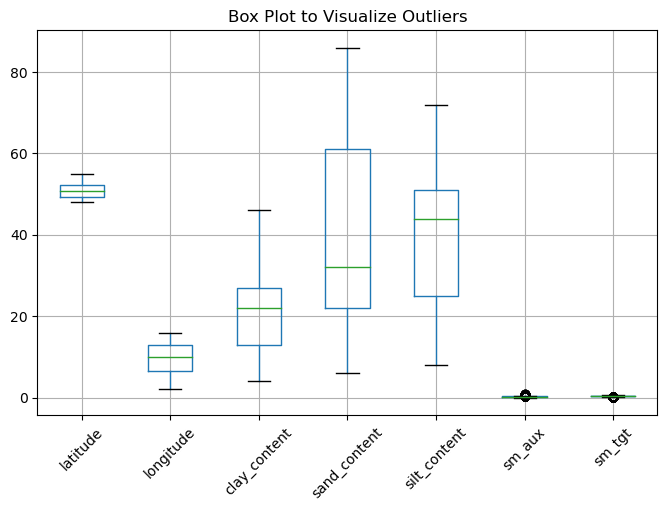

In [ ]:
# Automatically select numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns

# Box plot for each numeric column
df[numeric_cols].boxplot(figsize=(8, 5))
plt.title("Box Plot to Visualize Outliers")
plt.xticks(rotation=45)
plt.show()

We can see alot of Outliers in the `sm_aux` and `sm_tgt` features.

### Outlier Handling

In [ ]:
def remove_outliers(df, threshold=1.5):
    """
    Remove outliers from a DataFrame using the IQR method.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        threshold (float): The multiplier for the IQR to define outlier boundaries.
        
    Returns:
        pd.DataFrame: A new DataFrame with outliers removed.
    """
    # Automatically select numeric columns
    numeric_cols = df.select_dtypes(include=['number']).columns
    
    # Create a copy of the DataFrame to avoid modifying the original
    filtered_df = df.copy()
    
    for col in numeric_cols:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        
        # Calculate the Interquartile Range (IQR)
        IQR = Q3 - Q1
        
        # Define lower and upper bounds for outliers
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        # Remove rows with outliers
        filtered_df = filtered_df[(filtered_df[col] >= lower_bound) & (filtered_df[col] <= upper_bound)]
    
    return filtered_df

# Remove outliers and return a cleaned DataFrame
df_cleaned = remove_outliers(df)
print(f"Original DataFrame shape: {df.shape}")
print(f"Cleaned DataFrame shape: {df_cleaned.shape}")

Original DataFrame shape: (321584, 8)
Cleaned DataFrame shape: (313126, 8)


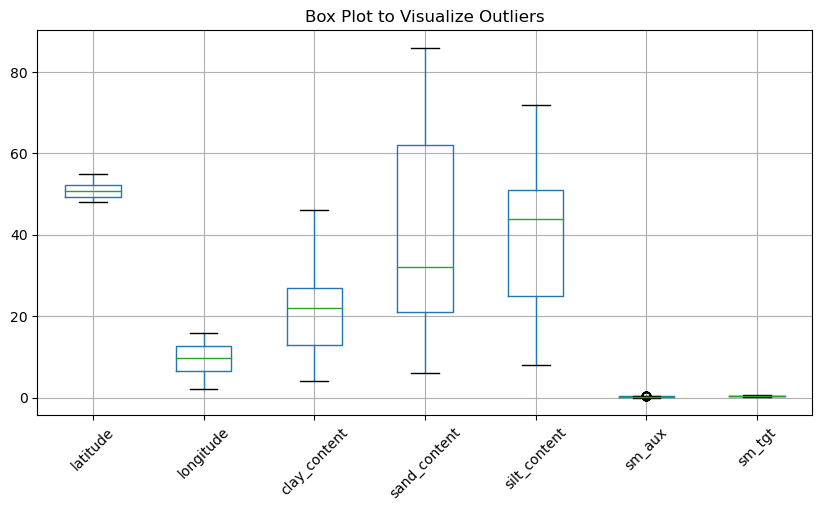

In [ ]:
# Automatically select numeric columns
numeric_cols = df_cleaned.select_dtypes(include=['number']).columns

# Box plot for each numeric column
df_cleaned[numeric_cols].boxplot(figsize=(10, 5))
plt.title("Box Plot to Visualize Outliers")
plt.xticks(rotation=45)
plt.show()

In [ ]:
df_cleaned.head()

,time,latitude,longitude,clay_content,sand_content,silt_content,sm_aux,sm_tgt
1,2013-01-05,54.875,9.125,5.0,86.0,9.0,0.437102,0.44
2,2013-01-07,54.875,9.125,5.0,86.0,9.0,0.412978,0.42
3,2013-01-08,54.875,9.125,5.0,86.0,9.0,0.378734,0.55
4,2013-01-09,54.875,9.125,5.0,86.0,9.0,0.350740,0.46
5,2013-01-10,54.875,9.125,5.0,86.0,9.0,0.323321,0.44


In [ ]:
df_cleaned['time'] = pd.to_datetime(df_cleaned['time'])
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 313126 entries, 1 to 321583
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   time          313126 non-null  datetime64[ns]
 1   latitude      313126 non-null  float64       
 2   longitude     313126 non-null  float64       
 3   clay_content  313126 non-null  float64       
 4   sand_content  313126 non-null  float64       
 5   silt_content  313126 non-null  float64       
 6   sm_aux        313126 non-null  float64       
 7   sm_tgt        313126 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 21.5 MB


In [ ]:
# Validate the Longitude and Latitude features

df_cleaned = df_cleaned[(df_cleaned['latitude'] >= -90) & (df_cleaned['latitude'] <= 90)]
df_cleaned = df_cleaned[(df_cleaned['longitude'] >= -180) & (df_cleaned['longitude'] <= 180)]

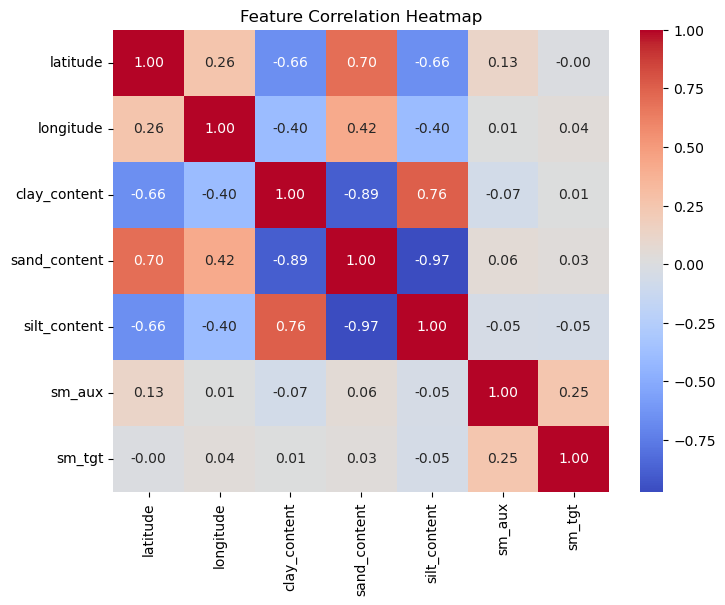

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(df_cleaned.select_dtypes(include=['number']).corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
# Save cleaned data for the next step
output_path = "data/cleaned_data.csv"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
df.to_csv(output_path, index=False)
print(f"Cleaned data saved to {output_path}")

# Exploratory Data Analysis

- Visualize relationships between soil moisture and soil texture (clay, sand, silt).
- Plot time series for soil moisture (sm_tgt) and auxiliary moisture (sm_aux).
- Use geographic visualization for spatial trends.

In [ ]:
data = pd.read_csv('data/processed_data.csv')

# Correlation heatmap
correlation = data[['clay_content', 'sand_content', 'silt_content', 'sm_aux', 'sm_tgt']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Time series plot for sm_tgt
plt.figure(figsize=(10, 5))
plt.plot(data['time'], data['sm_tgt'], label='Soil Moisture')
plt.title('Soil Moisture Over Time')
plt.xlabel('Time')
plt.ylabel('Soil Moisture')
plt.legend()
plt.show()

In [ ]:
# Visualization
sns.pairplot(df[['clay_content', 'sand_content', 'silt_content', 'sm_aux', 'sm_tgt']])
plt.savefig('figures/pairplot.png')

# Feature Engineering

In [ ]:
# SOil Texture ratio
df_cleaned['clay_to_sand'] = df_cleaned['clay_content'] / (df_cleaned['sand_content'] + 1e-6)
df_cleaned['sand_to_silt'] = df_cleaned['sand_content'] / (df_cleaned['silt_content'] + 1e-6)

In [ ]:
# Time base features

df_cleaned['month'] = df_cleaned['time'].dt.month
df_cleaned['year'] = df_cleaned['time'].dt.year
df_cleaned['day_of_year'] = df_cleaned['time'].dt.dayofyear

# Modeling
- Define the target (sm_tgt) and features.
- Split data into training, validation, and test sets.
- Train multiple models (e.g., linear regression, random forest, XGBoost).
- Save models to results/model.pkl.

We will use regression models (e.g., Linear Regression, Random Forest Regressor) to predict sm_tgt.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd

def train_model(data):
    X = data[['clay_content', 'sand_content', 'silt_content', 'sm_aux']]
    y = data['sm_tgt']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    print(f'Mean Absolute Error: {mae}')
    print(f'Root Mean Squared Error: {rmse}')
    return model

# Load data
data = pd.read_csv('data/processed_data.csv')
model = train_model(data)

# Evaluation
- Evaluate model performance using metrics like RMSE and R².
- Save evaluation metrics to results/metrics.json.
- Visualize predictions vs. actual values.